<a href="https://colab.research.google.com/github/erdeminanc/Airbnb-new-user-bookings/blob/master/airbnb.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [319]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
!update-alternatives --set java /usr/lib/jvm/java-8-openjdk-amd64/jre/bin/java
!java -version
!pip install pyspark

openjdk version "1.8.0_252"
OpenJDK Runtime Environment (build 1.8.0_252-8u252-b09-1~18.04-b09)
OpenJDK 64-Bit Server VM (build 25.252-b09, mixed mode)


In [320]:
from pyspark import SparkContext, SQLContext
from pyspark.sql import SparkSession
from pyspark.sql.functions import isnan, when, count, col, UserDefinedFunction, lit, unix_timestamp, from_unixtime, datediff
from pyspark.sql import functions as func
from pyspark.sql.types import DoubleType

from pyspark.ml.feature import VectorAssembler, StringIndexer,OneHotEncoder

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

#disable warnings
import warnings
warnings.filterwarnings('ignore')

# Draw inline
%matplotlib inline

# Set figure aesthetics
sns.set_style("white", {'ytick.major.size': 10.0})
sns.set_context("poster", font_scale=1.1)



In [321]:
spark = SparkSession.builder.appName('airbnb').getOrCreate()
sc = spark.sparkContext
sql = SQLContext(sc)

In [322]:
from google.colab import drive
drive.mount("/content/gdrive")

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


## Users.csv (Features for Registered Users)

In [323]:
dfUser = spark.read.csv('gdrive/My Drive/it542-labs/Project/data/train_users.csv',inferSchema=True, header=True)

In [324]:
dfUser.show(5)

+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|   gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+----------+--------------------+----------------------+------------------+---------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|gxn3p5htnn|          2010-06-28|        20090319043255|              null|-unknown-|null|     facebook|          0|      en|           direct|            direct|              untracked|       Web|      Mac Desktop|       Chrome|                NDF|


In [325]:
dfUser.columns

['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination']

In [326]:
dfUser.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: long (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)



Column Details:

- 'id'
- 'date_account_created',
- 'timestamp_first_active',
-'date_first_booking',
- 'gender',** (male/female)**
- 'age',
- 'signup_method', **(facebook/twitter/basic)**
- 'signup_flow', **(the page where user came from to signup)**
- 'language',
- 'affiliate_channel', **(kind of paid marketing eg. direct, seo)**
- 'affiliate_provider', **(which paid marketing)**
- 'first_affiliate_tracked', **(marketing type user interaced for the first time)**
- 'signup_app', **(web/mobil)**
- 'first_device_type', **(mac, windows, ios, android)**
- 'first_browser',
- 'country_destination' **(target)**]

## 1. Exploratory Data Analysis on Users.csv



In [327]:
print("Number of users: ", dfUser.count())

Number of users:  213451


In [328]:
dfUser.describe().show()

+-------+----------+--------------------+----------------------+------------------+---------+------------------+-------------+------------------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|summary|        id|date_account_created|timestamp_first_active|date_first_booking|   gender|               age|signup_method|       signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+-------+----------+--------------------+----------------------+------------------+---------+------------------+-------------+------------------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|  count|    213451|              213451|                213451|             88908|   213451|            125461|       213451|            213451|  213451|         

In [329]:
print("**** Count missing values in rows ****")
dfUser.select([count(when(isnan(c), c)).alias(c) for c in dfUser.columns]).show()

**** Count missing values in rows ****
+---+--------------------+----------------------+------------------+------+---+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
| id|date_account_created|timestamp_first_active|date_first_booking|gender|age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+---+--------------------+----------------------+------------------+------+---+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|  0|                   0|                     0|                 0|     0|  0|            0|          0|       0|                0|                 0|                      0|         0|                0|            0|                  0|
+---+

In [330]:
print("**** Count of null values in rows ****")

dfUser.select([count(when(col(c).isNull(), c)).alias(c) for c in dfUser.columns]).show()

**** Count of null values in rows ****
+---+--------------------+----------------------+------------------+------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
| id|date_account_created|timestamp_first_active|date_first_booking|gender|  age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|
+---+--------------------+----------------------+------------------+------+-----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+
|  0|                   0|                     0|            124543|     0|87990|            0|          0|       0|                0|                 0|                   6065|         0|                0|            0|                  

so there are null values in;
- date_first_booking
- age
- first-affiliate tracked

In [331]:
dfUser.select("gender").distinct().show()

+---------+
|   gender|
+---------+
|     MALE|
|    OTHER|
|-unknown-|
|   FEMALE|
+---------+



Let's replace -unknown- fields with null...

In [332]:
dfUser = dfUser.withColumn("gender", func.when(dfUser["gender"]=="-unknown-",None).otherwise(dfUser["gender"]))

Deep dive into age column

In [333]:
dfUser.select("Age").describe().show()

+-------+------------------+
|summary|               Age|
+-------+------------------+
|  count|            125461|
|   mean| 49.66833517985669|
| stddev|155.66661183021546|
|    min|               1.0|
|    max|            2014.0|
+-------+------------------+



We find out that: **there are people with the age of 2014 and 1**

For the ages higher than 1000, I will deduct **df["age"] from 2015**, as the dataset was taken on 2015.

In [334]:
print("Number of people entered values higher than 1000 to the age column: ", end="")
dfUser.filter("Age>1000").select("Age").count()

Number of people entered values higher than 1000 to the age column: 

779

In [335]:
print("Number of people entered values less than 18 to the age column: ", end="")
dfUser.filter("Age<18").select("Age").count()

Number of people entered values less than 18 to the age column: 

158

In [336]:
dfUser = dfUser.withColumn("age", when(col("age")> 1000, (2015 - col("age"))).otherwise(col("age")))

In [337]:
dfUser.select("age").describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|            125461|
|   mean|  37.2054582699006|
| stddev|14.209254887411133|
|    min|               1.0|
|    max|             150.0|
+-------+------------------+



In [338]:
dfUser = dfUser.withColumn("age", when(col("age")< 18, None).otherwise(col("age")))


In [339]:
dfUser.select("age").describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|            124553|
|   mean| 37.45482645941888|
| stddev|13.950188056552165|
|    min|              18.0|
|    max|             150.0|
+-------+------------------+



In [340]:
dfUser = dfUser.withColumn("age", when(col("age")> 95, None).otherwise(col("age")))

In [341]:
dfUser.select("age").describe().show()

+-------+------------------+
|summary|               age|
+-------+------------------+
|  count|            122894|
|   mean|36.538700017901604|
| stddev|11.580059924446937|
|    min|              18.0|
|    max|              95.0|
+-------+------------------+



Finally, ages are fixed. There is noone under 18 and over 95.

### User Ages

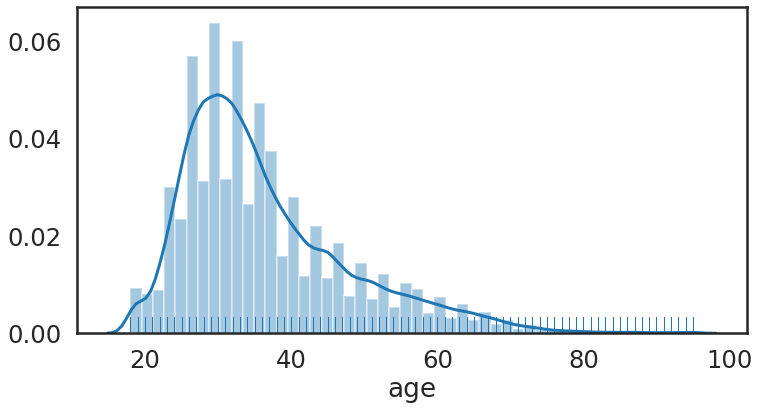

In [342]:
#Visualize Ages Distribution
df_age = dfUser.na.drop(subset=["age"]).select("age").toPandas()

plt.figure(figsize=(12,6))
sns.distplot(df_age["age"], rug=True)
plt.show()

As we can see, most of the users are between ages 20-40


### User Gender

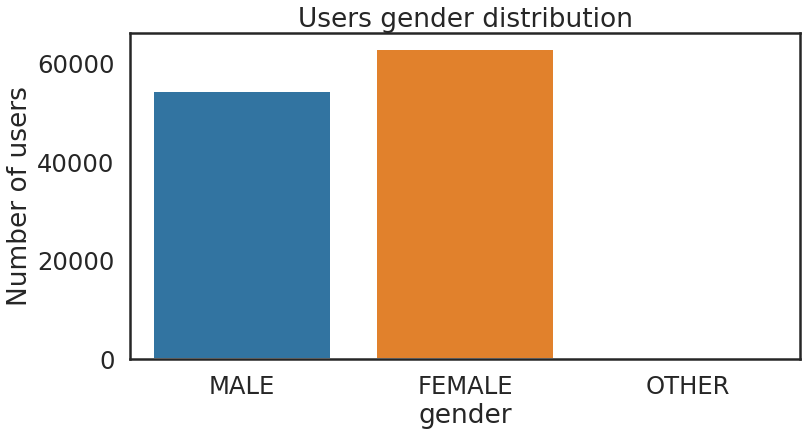

Number of other genders:  282


In [343]:
#Visualize Gender Distribution
df_gender = dfUser.na.drop(subset=["gender"]).select("gender").toPandas()

plt.figure(figsize=(12,6))
sns.countplot(x='gender', data=df_gender)
plt.ylabel('Number of users')
plt.title('Users gender distribution')
plt.show()


print("Number of other genders: " , len(df_gender[df_gender['gender'] == 'OTHER']))


In [344]:
dfTarget = dfUser.na.drop(subset=["country_destination"]).select(["country_destination", "first_browser",
                                                                  "first_device_type" ,"affiliate_channel",
                                                                  "age", "signup_method", "signup_app", 
                                                                  "language", "date_account_created", 
                                                                  "timestamp_first_active"]).toPandas()
df_target_without_NDF = dfTarget[dfTarget['country_destination']!='NDF']

I picked some features for plotting.

## Travel Destination (Target Variable)

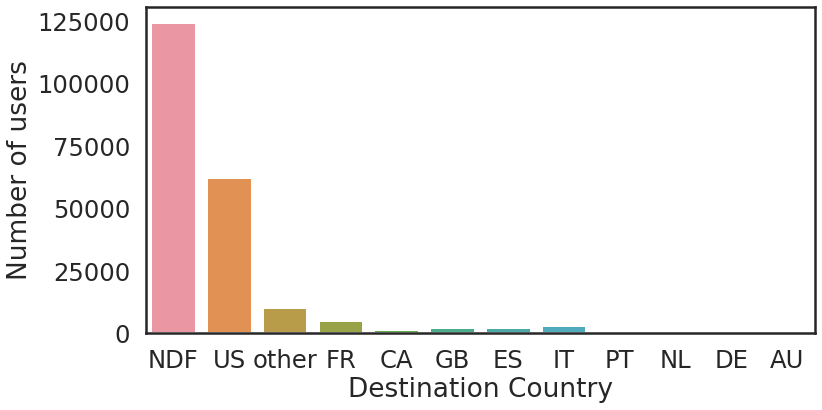

In [345]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=dfTarget)
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.show()

Around 120.000 of all users didn't end up booking any trip, which is represented with NDF. US follows that, which makes sense, because dataset comes from US users.

## Country Destination vs Age

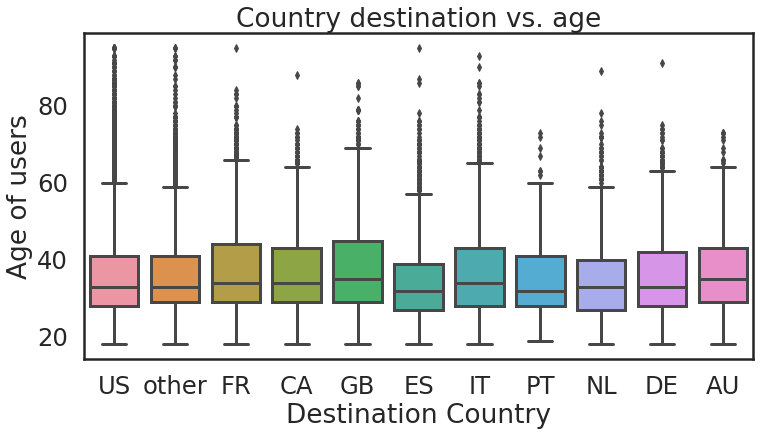

In [346]:
plt.figure(figsize=(12,6))
sns.boxplot(y='age' , x='country_destination',data=df_target_without_NDF)
plt.xlabel('Destination Country')
plt.ylabel('Age of users')
plt.title('Country destination vs. age')
plt.show()

We can see that there is no significant difference based on destinations considering age feature. However users who have bookings to Great Britain, seems to be older than the other users.

## Users vs Signup Method

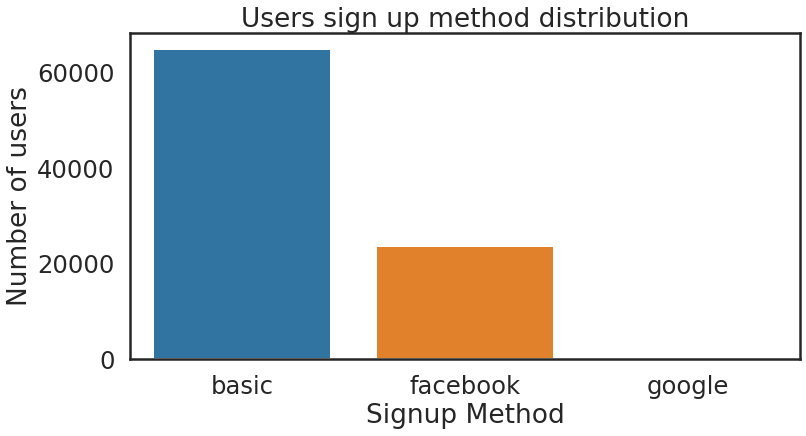

In [347]:
plt.figure(figsize=(12,6))
sns.countplot(x='signup_method', data = df_target_without_NDF)
plt.xlabel('Signup Method')
plt.ylabel('Number of users')
plt.title('Users sign up method distribution')
plt.show()

We can clearly see that, most the users signed up to Airbnb using basic signup form.

## Signup method vs Destination

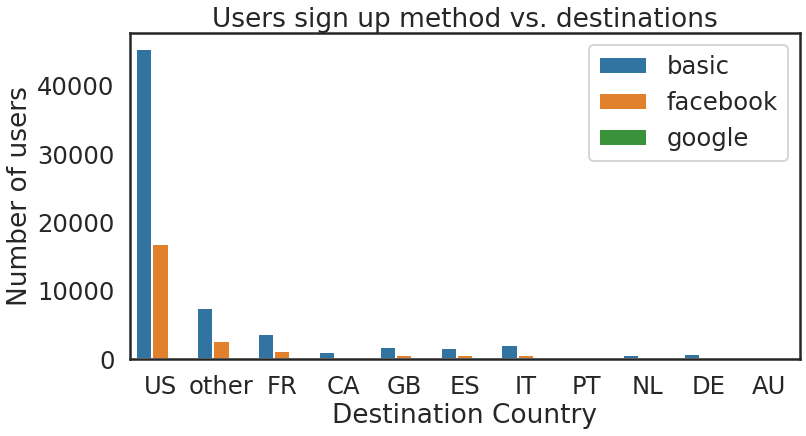

In [348]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data = df_target_without_NDF, hue = 'signup_method')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Users sign up method vs. destinations')
plt.legend(loc='upper right')
plt.show()

From the figure above, we see that users prefer basic signup irrespective of destination.

## Signup App Distribution

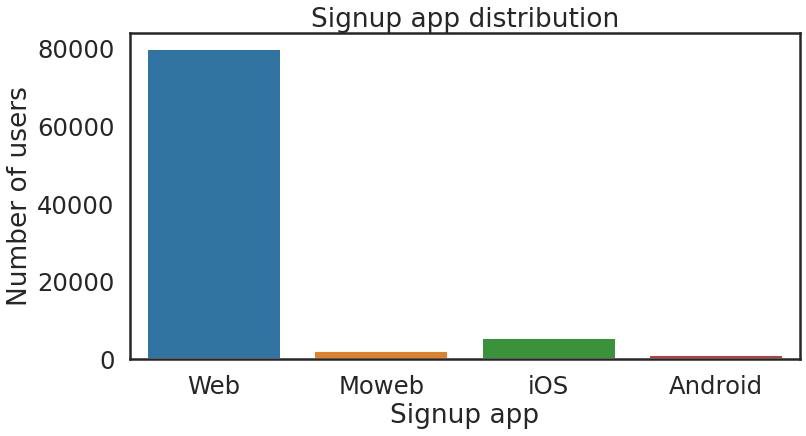

In [349]:
plt.figure(figsize=(12,6))
sns.countplot(x='signup_app', data=df_target_without_NDF)
plt.xlabel('Signup app')
plt.ylabel('Number of users')
plt.title('Signup app distribution')
plt.show()

Majority of users, signup using Airbnb's website. Next majority of users sign up using iOS application. 



## Destination Country based on signup

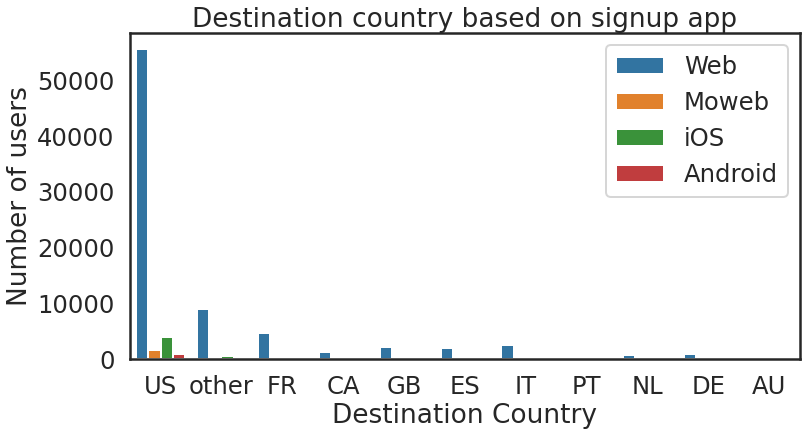

In [350]:
plt.figure(figsize=(12,6))
sns.countplot(x='country_destination', data=df_target_without_NDF, hue='signup_app')
plt.xlabel('Destination Country')
plt.ylabel('Number of users')
plt.title('Destination country based on signup app')
plt.legend(loc = 'upper right')
plt.show()

It seems that most only users of planning visits to US have a significant signups from platforms other than web. Other destinations have nearly no signups from other platformds.

## Affiliate

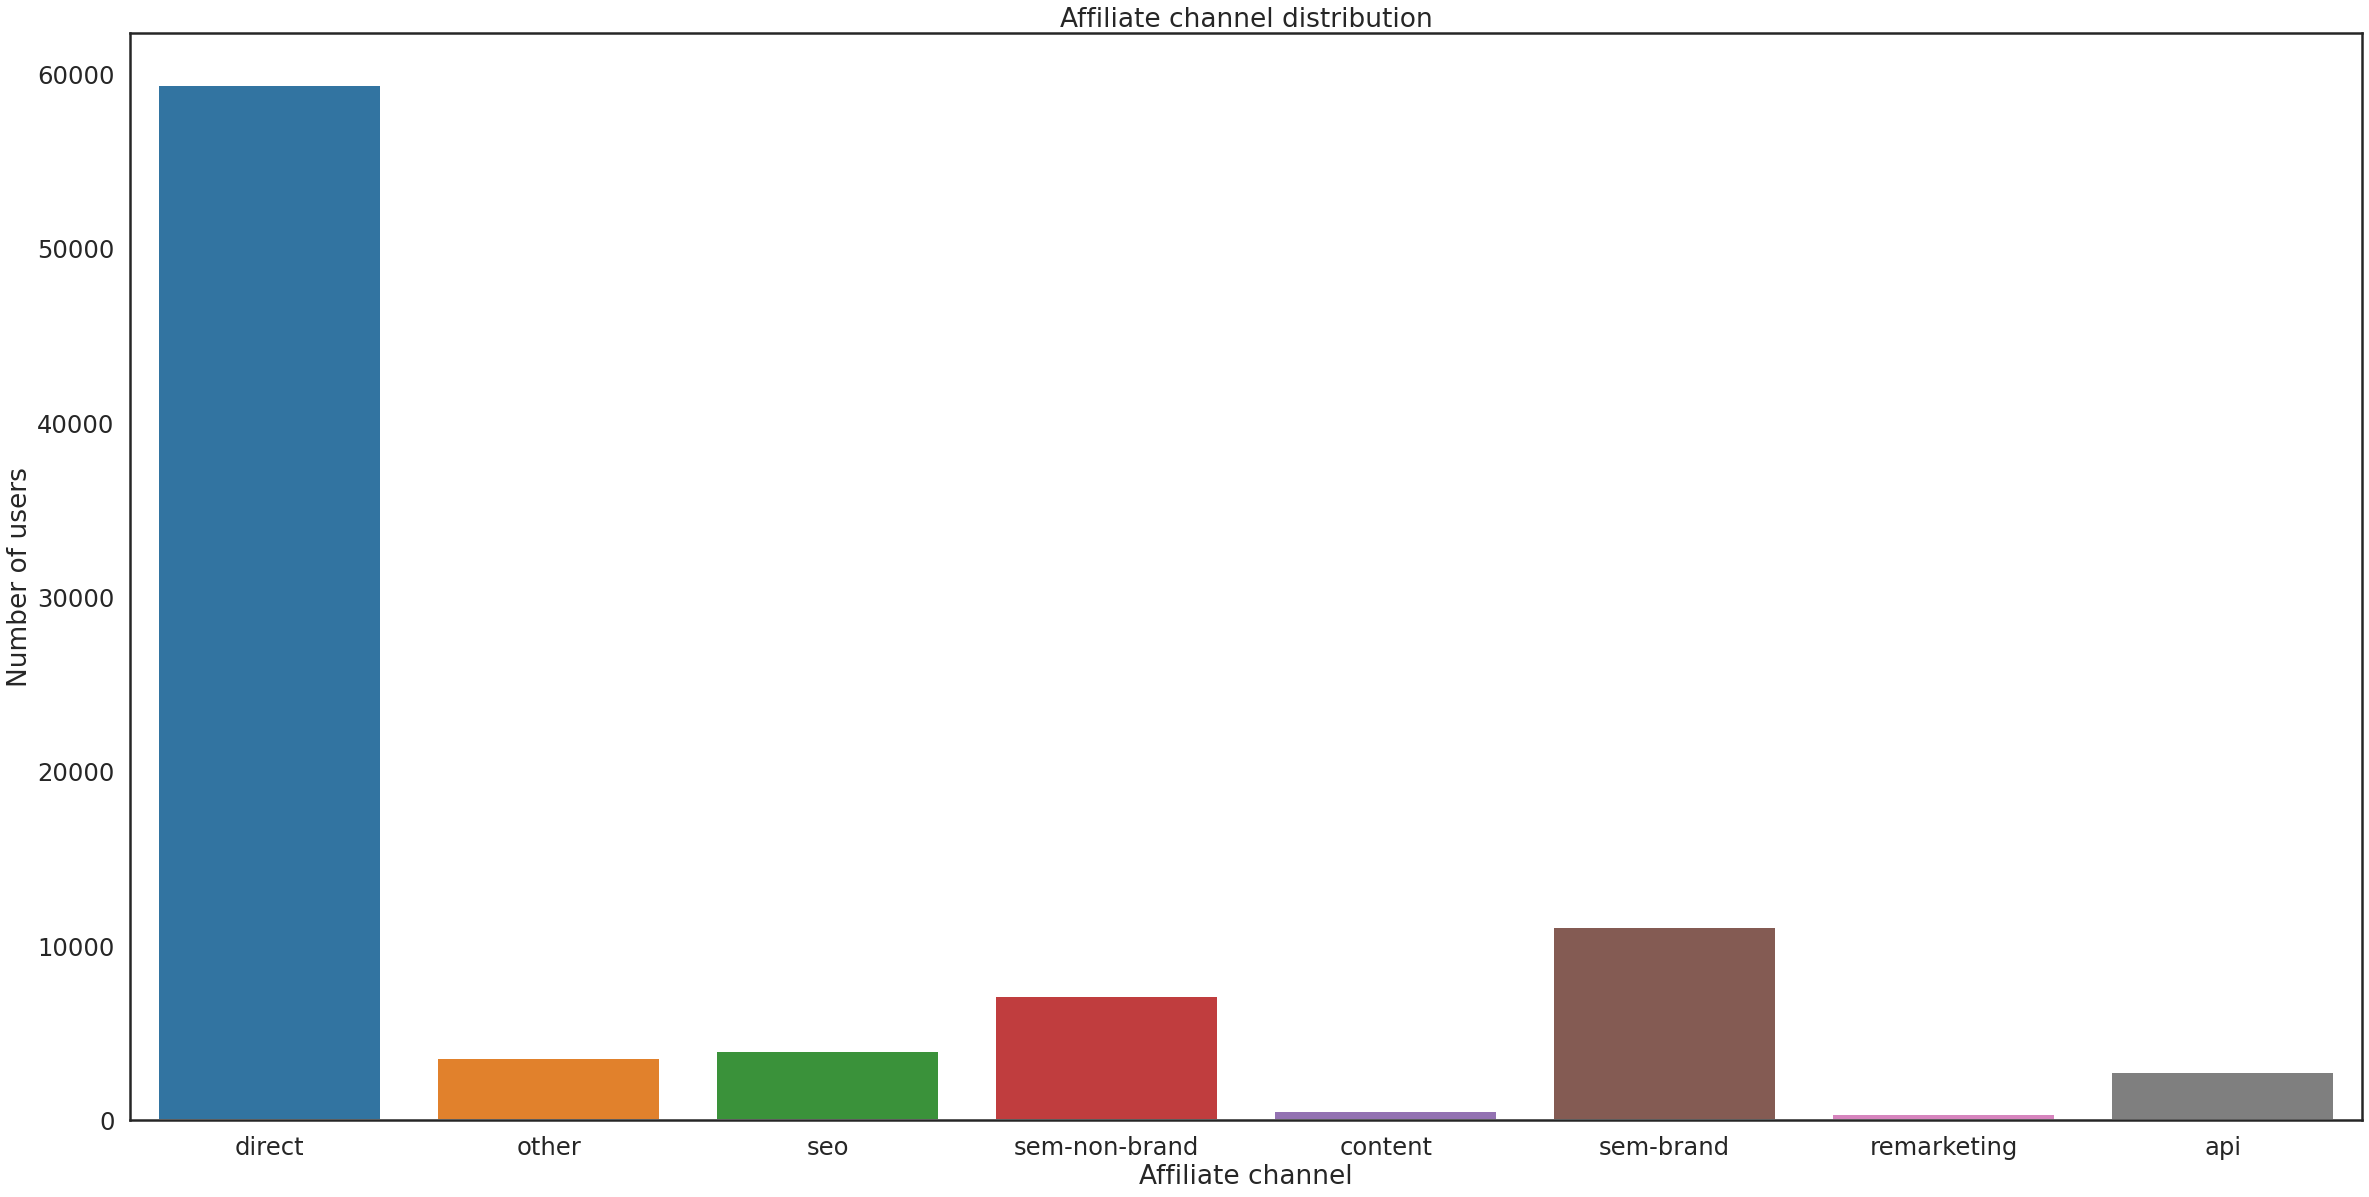

In [351]:
plt.figure(figsize=(40,20))
sns.countplot(x='affiliate_channel', data=df_target_without_NDF)
plt.xlabel('Affiliate channel')
plt.ylabel('Number of users')
plt.title('Affiliate channel distribution')
plt.show()

Most Airbnb users come to website directly, as we can see above.

## First Device Type Distribution

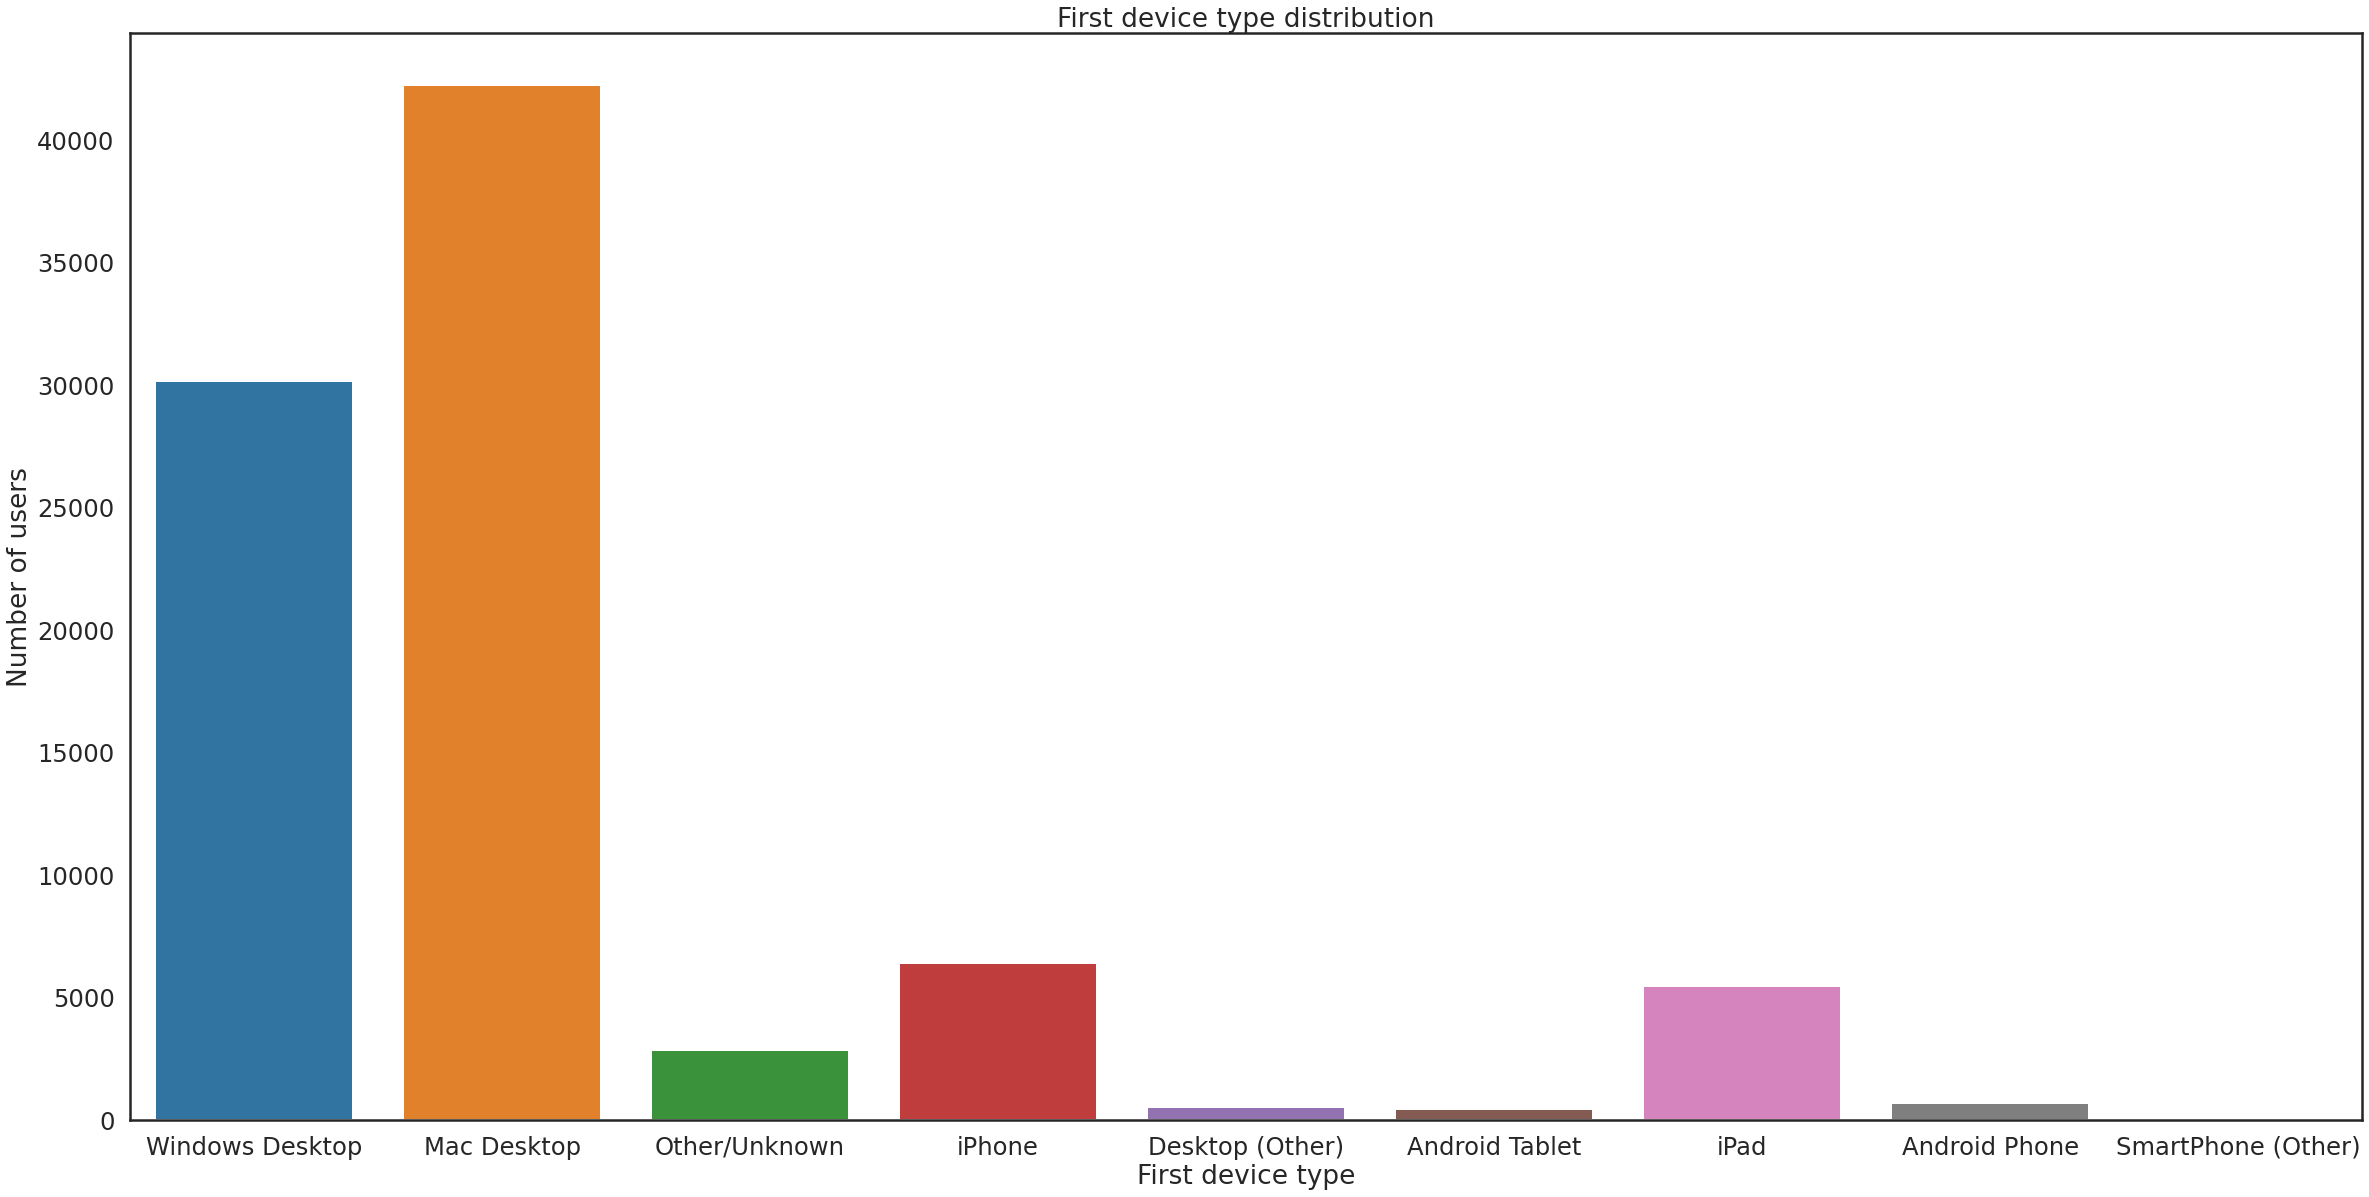

In [352]:
plt.figure(figsize=(40,20))
sns.countplot(x='first_device_type', data=df_target_without_NDF)
plt.xlabel('First device type')
plt.ylabel('Number of users')
plt.title('First device type distribution')
plt.show()

According to figure above, most popular device on Airbnb's website is Mac desktop, followed by Windows desktop.

## First device type vs. country destination

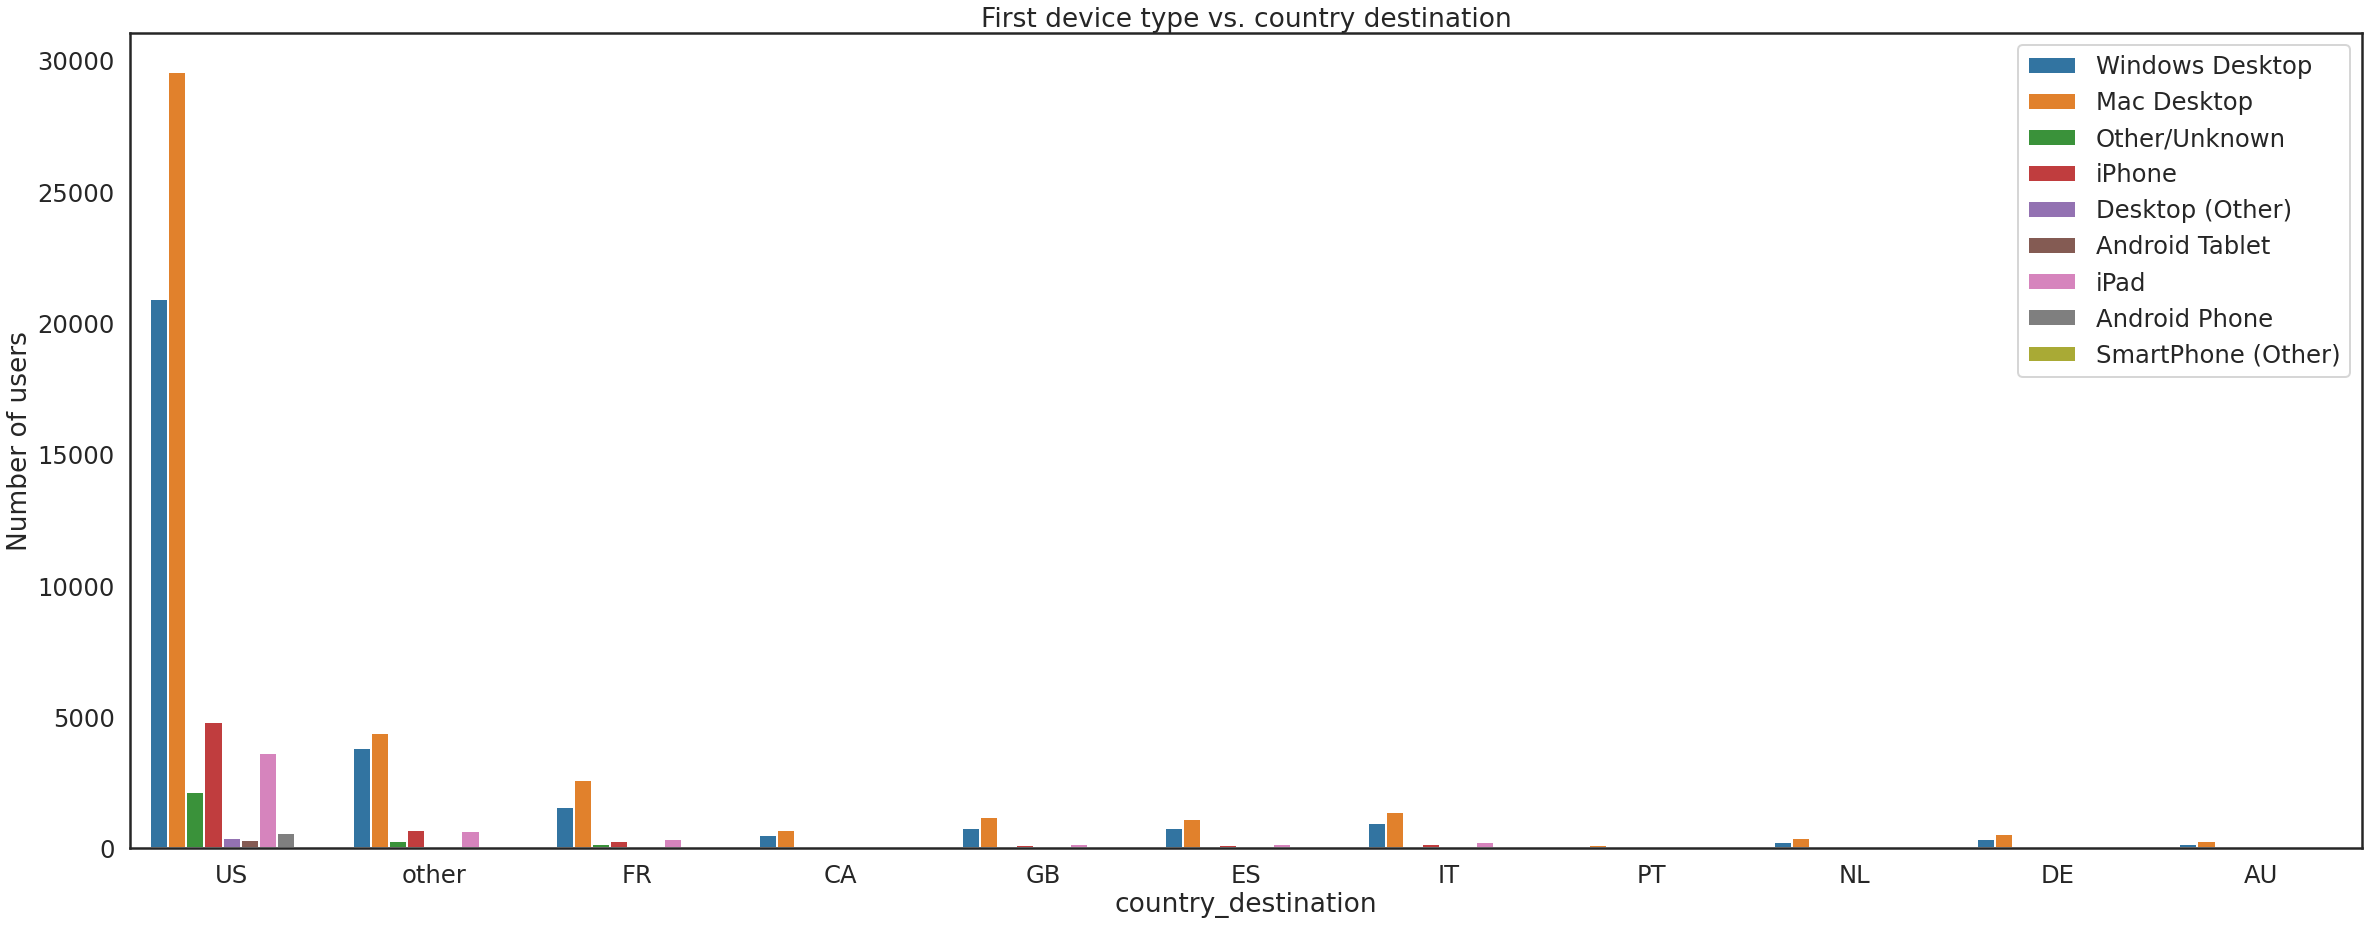

In [353]:
plt.figure(figsize=(40,15))
sns.countplot(x='country_destination', data=df_target_without_NDF, hue='first_device_type')
plt.ylabel('Number of users')
plt.title('First device type vs. country destination')
plt.legend(loc = 'upper right')
plt.show()

## First browser distribution

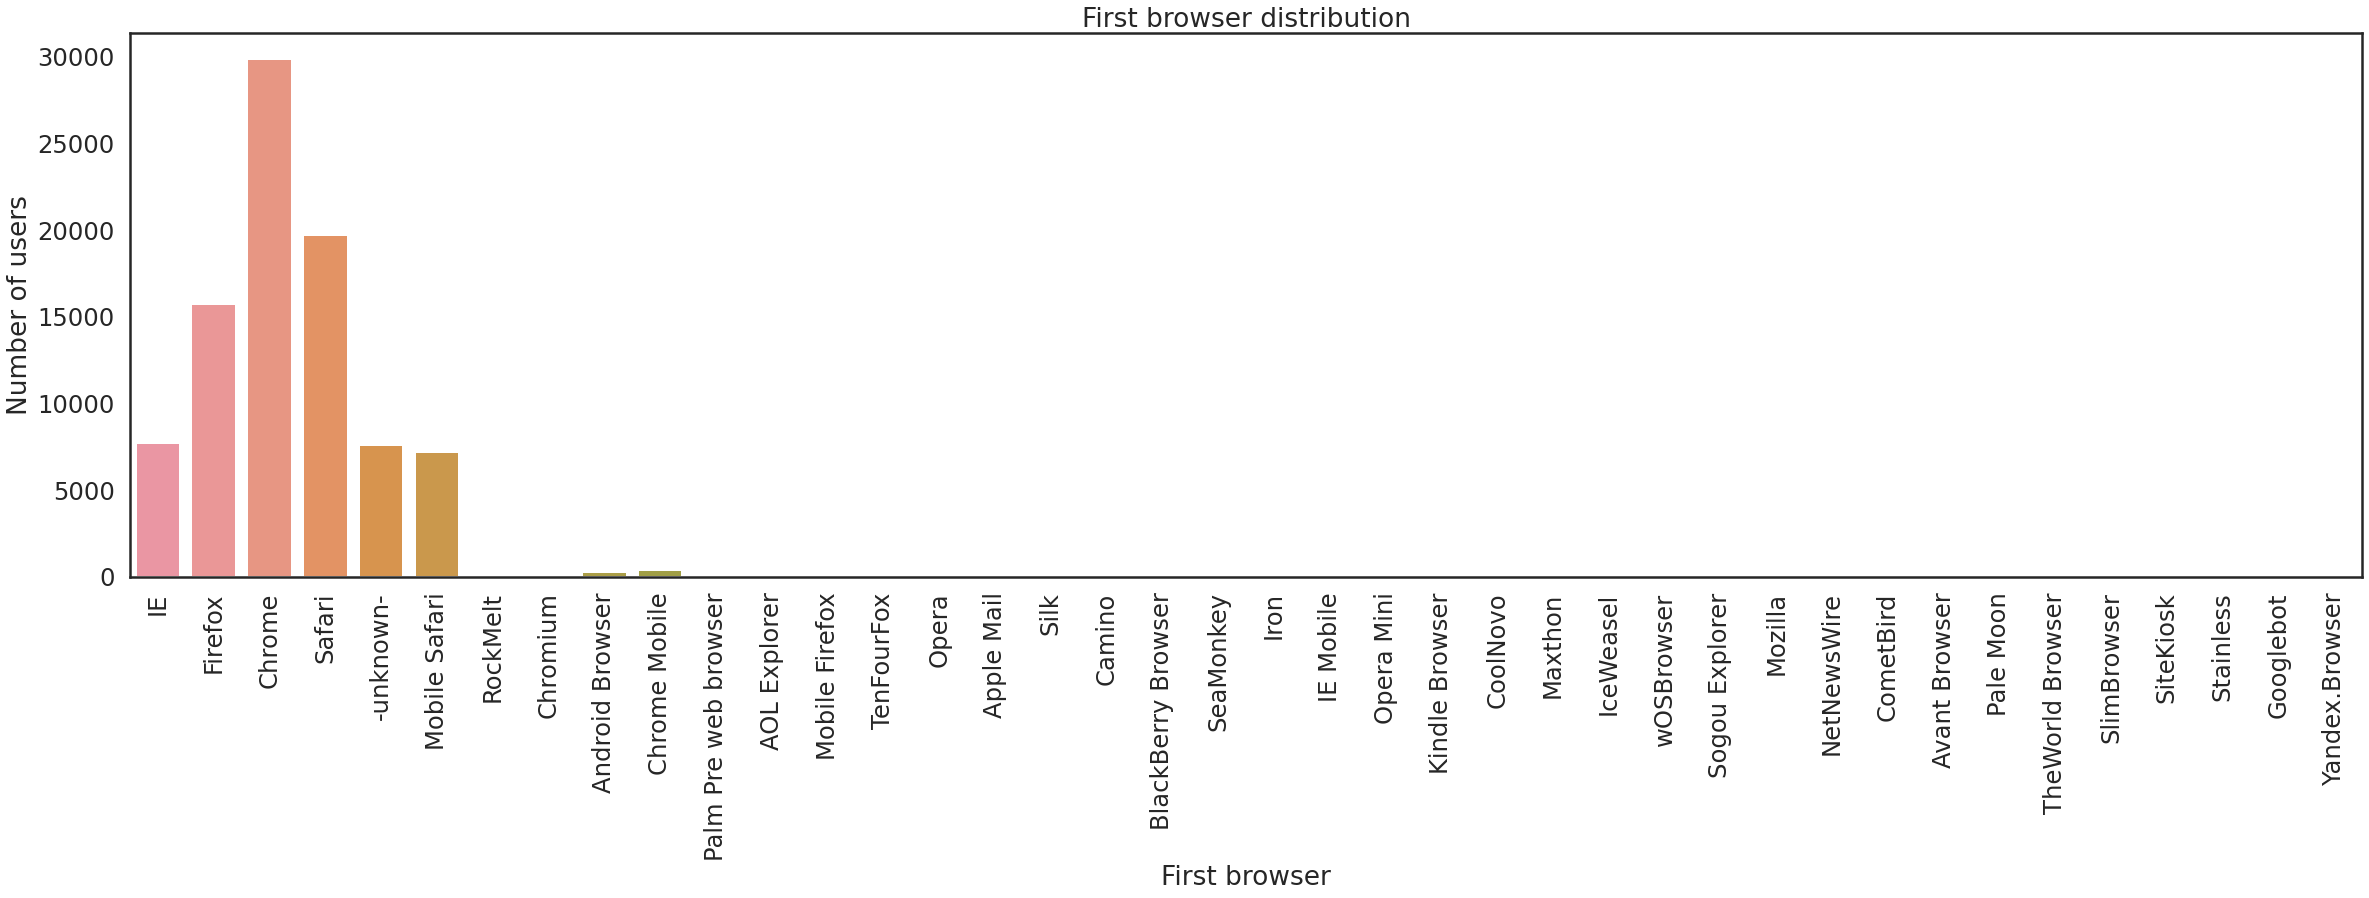

In [354]:
plt.figure(figsize=(40,10))
sns.countplot(x='first_browser', data=df_target_without_NDF)
plt.xlabel('First browser')
plt.ylabel('Number of users')
plt.title('First browser distribution')
plt.xticks(rotation=90)
plt.show()

Most popular browser is Chrome, followed by Safari and Firefox on Airbnb's website.

## Language Distribution

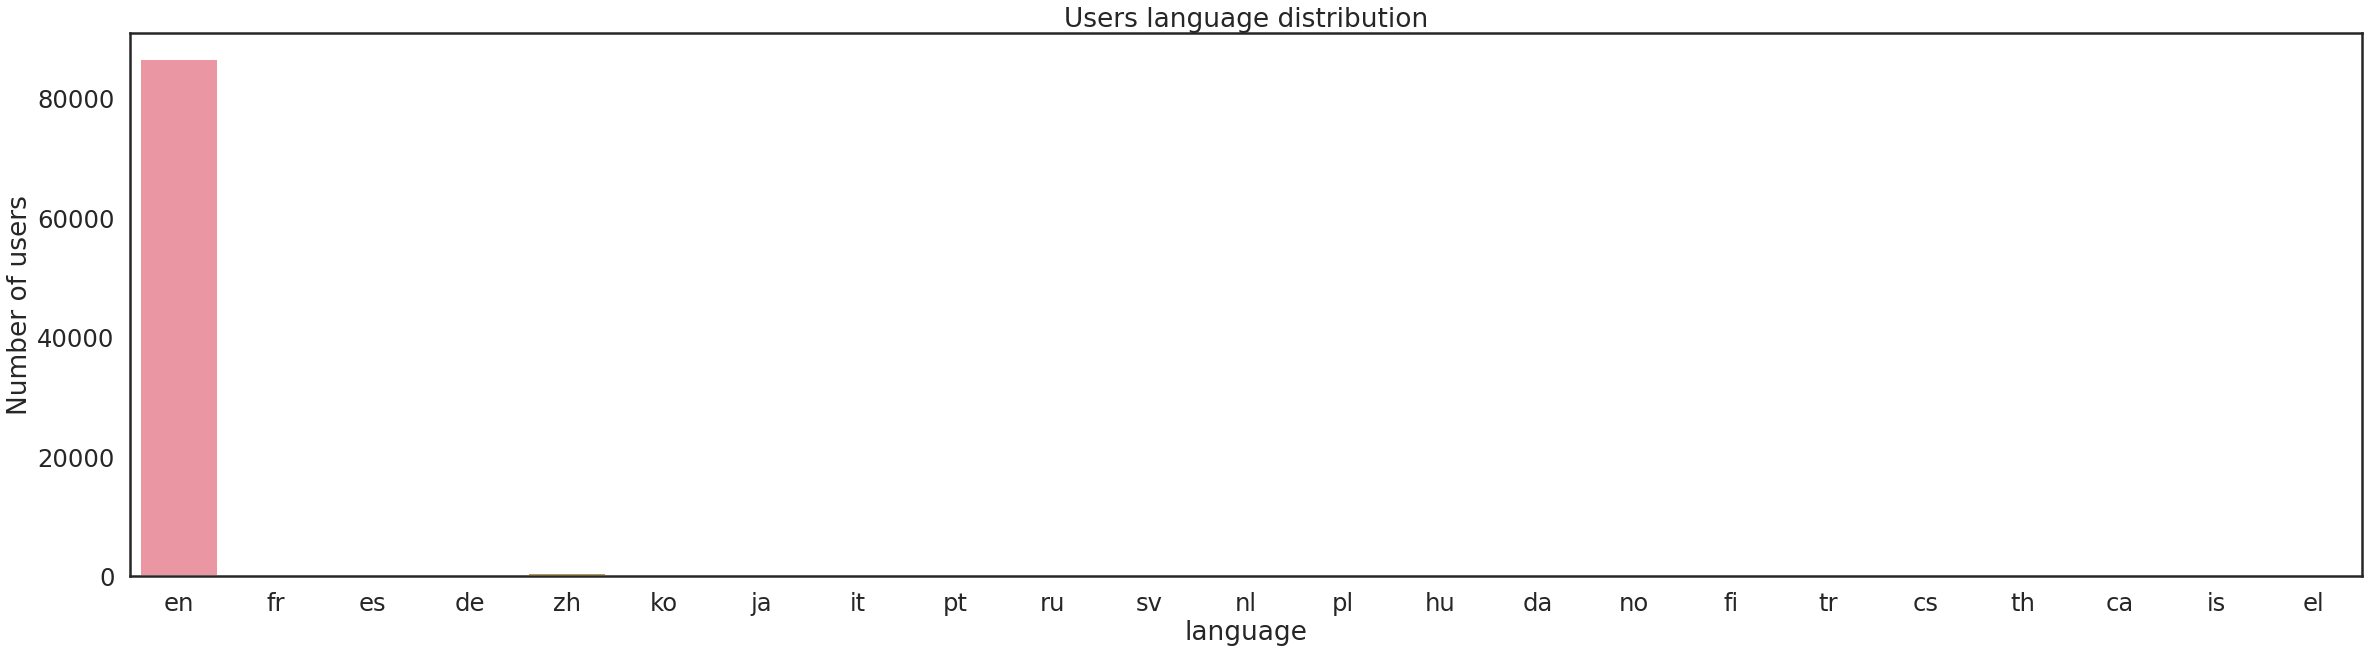

In [355]:
plt.figure(figsize=(40,10))
sns.countplot(x='language', data=df_target_without_NDF)
plt.xlabel('language')
plt.ylabel('Number of users')
plt.title('Users language distribution')
plt.show()

As expected, almost all users prefer English, as the data comes from Airbnb users of United States.

## New accounts created over time

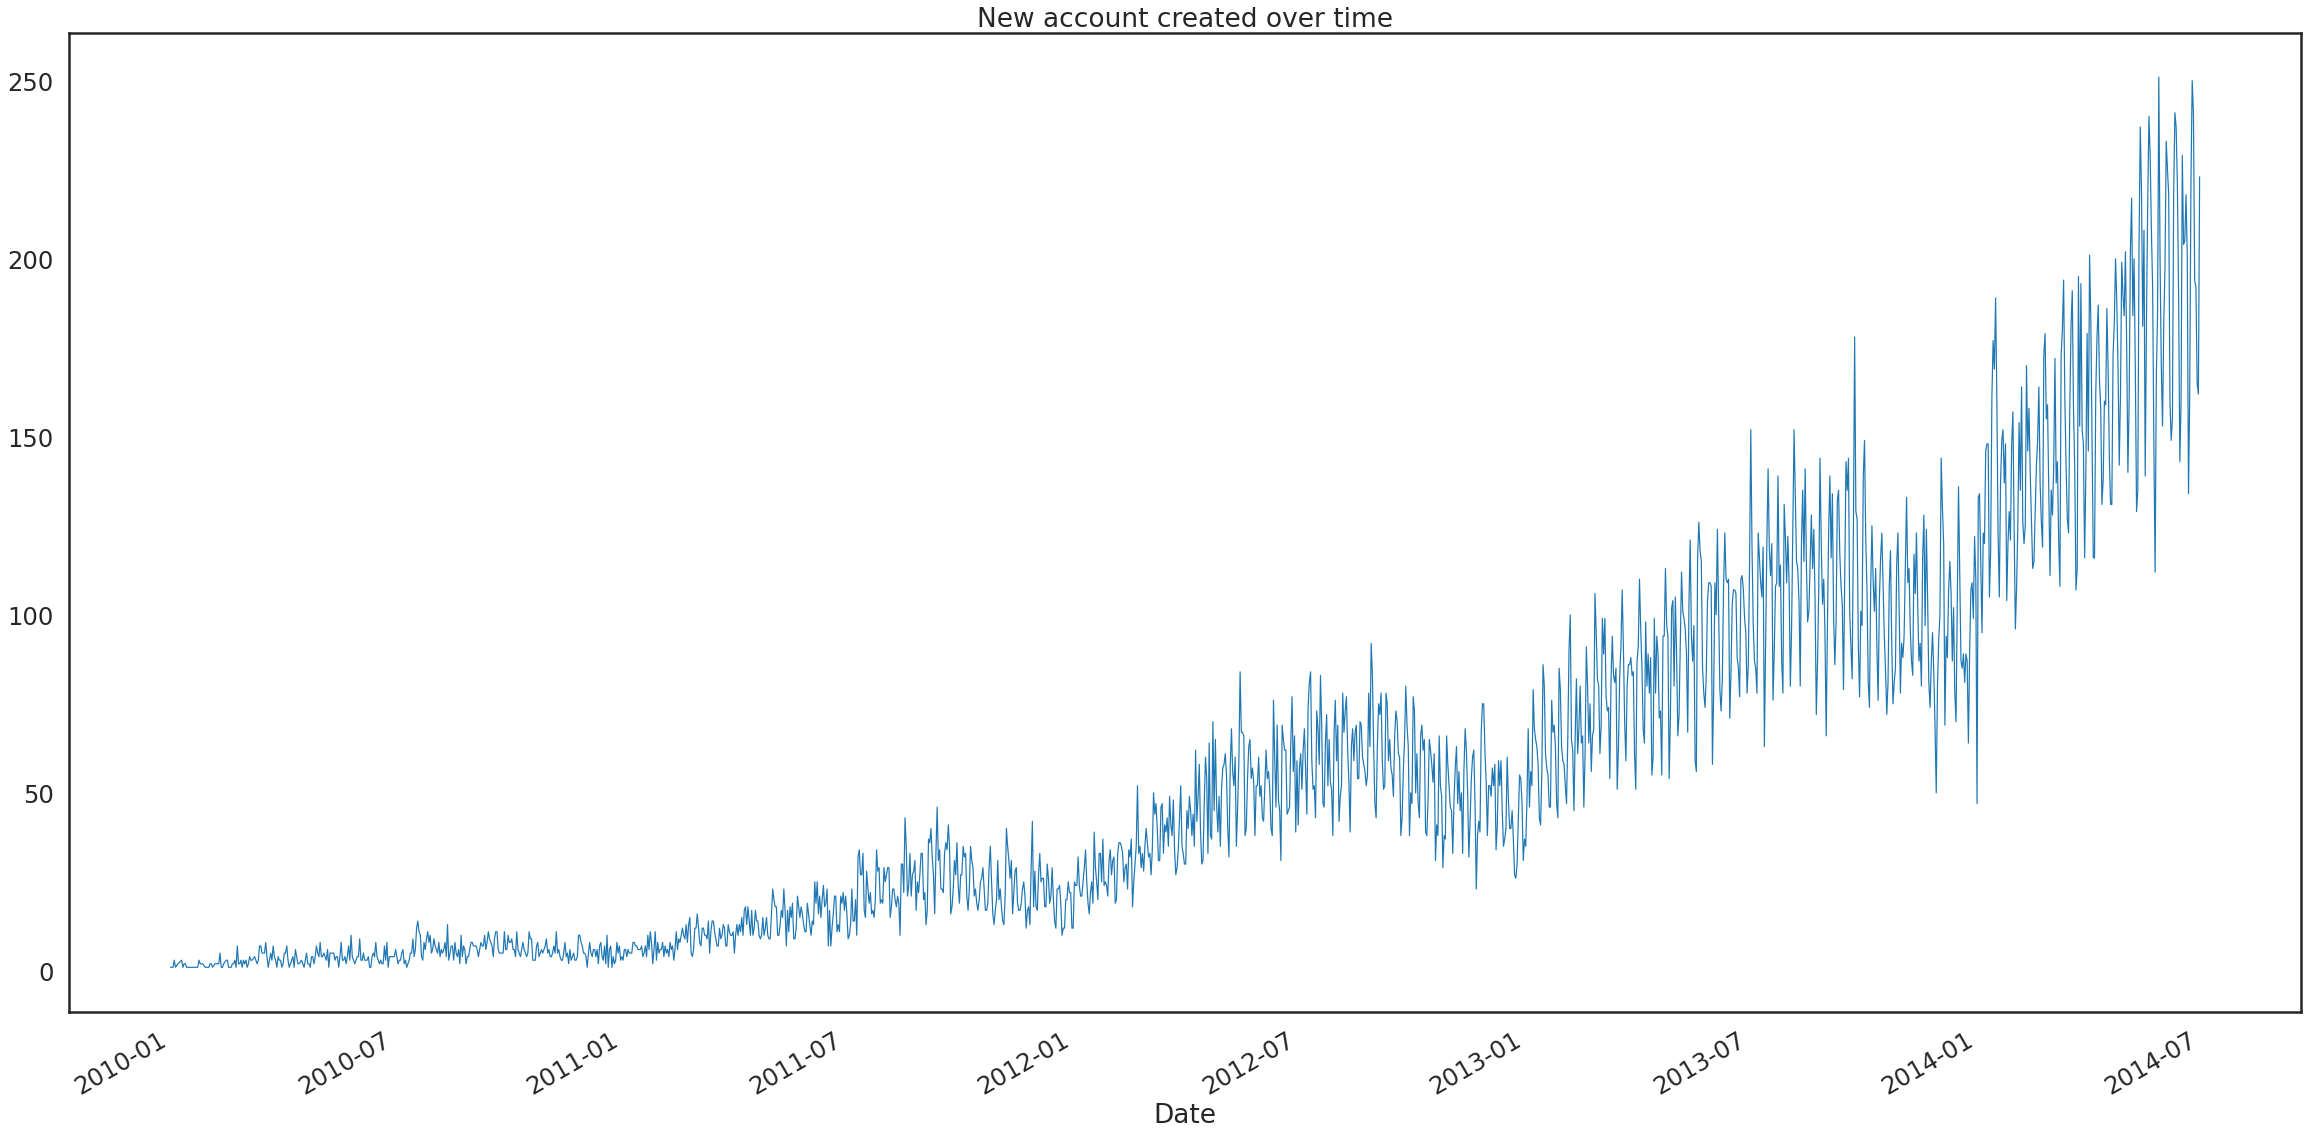

In [356]:
df_target_without_NDF['date_account_created'] = pd.to_datetime(df_target_without_NDF['date_account_created'])
df_target_without_NDF['timestamp_first_active'] = pd.to_datetime((df_target_without_NDF.timestamp_first_active)//1000000, format='%Y%m%d')
plt.figure(figsize=(40,20))
df_target_without_NDF.date_account_created.value_counts().plot(kind='line', linewidth=1.2)
plt.xlabel('Date')
plt.title('New account created over time')
plt.show()

After mid 2013, there is a significant increase on the number of new users on the platform.

## Analyse on 2013

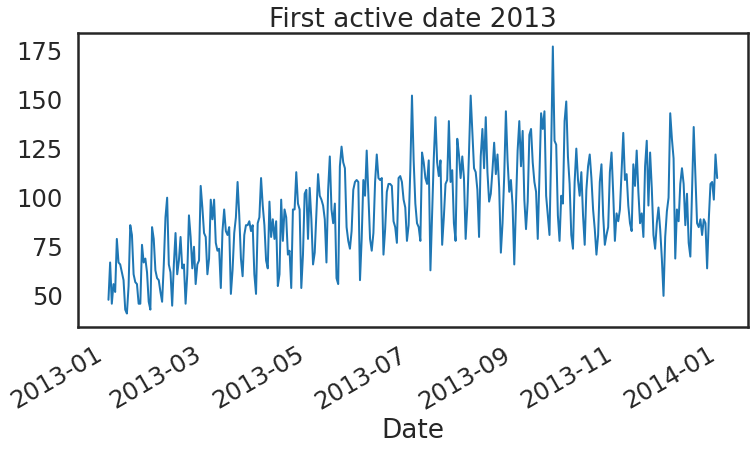

In [357]:
df_2013 = df_target_without_NDF[df_target_without_NDF['timestamp_first_active'] > pd.to_datetime(20130101, format='%Y%m%d')]
df_2013 = df_2013[df_2013['timestamp_first_active'] < pd.to_datetime(20140101, format='%Y%m%d')]

plt.figure(figsize=(12,6))
df_2013.timestamp_first_active.value_counts().plot(kind='line', linewidth=2)
plt.xlabel('Date')
plt.title('First active date 2013')
plt.show()

I analysed 2013 further, as we can see peak months are July, August and October.


# 2. Exploratory Data Analysis on Sessions.csv

## Sessions.csv (web sessions log for users)

In [358]:
dfSessions = spark.read.csv('gdrive/My Drive/it542-labs/Project/data/sessions.csv', inferSchema=True, header=True)

In [359]:
dfSessions.show(5)

+----------+--------------+-----------+-------------------+---------------+------------+
|   user_id|        action|action_type|      action_detail|    device_type|secs_elapsed|
+----------+--------------+-----------+-------------------+---------------+------------+
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       319.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     67753.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       301.0|
|d1mm9tcy42|search_results|      click|view_search_results|Windows Desktop|     22141.0|
|d1mm9tcy42|        lookup|       null|               null|Windows Desktop|       435.0|
+----------+--------------+-----------+-------------------+---------------+------------+
only showing top 5 rows



In [360]:
dfSessions.printSchema()

root
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)



Column Details: 
- 'user_id', **(id to be joined with dfUsers' id column)**
- 'action', **(lookup, search_results)**
- 'action_type', **(click, drag etc.)**
- 'action_detail', **(view, search)**
- 'device_type', **(windows, mac, ios etc)**
- 'secs_elapsed'

In [361]:
print("Number of rows in file: ", dfSessions.count())

Number of rows in file:  10567737


In [362]:
print("Number of unique users in file: ", dfSessions.select("user_id").distinct().count())

Number of unique users in file:  135484


In [363]:
dfSessions.describe().show()

+-------+----------+------------------+-----------+-------------+-----------+-----------------+
|summary|   user_id|            action|action_type|action_detail|device_type|     secs_elapsed|
+-------+----------+------------------+-----------+-------------+-----------+-----------------+
|  count|  10533241|          10488111|    9441533|      9441533|   10567737|         10431706|
|   mean|      null|11.445711108021687|       null|         null|       null|19405.81075070559|
| stddev|      null|1.7023772142506772|       null|         null|       null| 88884.2432085718|
|    min|00023iyk9l|                10|  -unknown-|    -unknown-|  -unknown-|              0.0|
|    max|zzzlylp57e| zendesk_login_jwt|       view|   your_trips|  iPodtouch|        1799977.0|
+-------+----------+------------------+-----------+-------------+-----------+-----------------+



In [364]:
print("**** Count missing values in rows ****")
dfSessions.select([count(when(isnan(c), c)).alias(c) for c in dfSessions.columns]).show()

**** Count missing values in rows ****
+-------+------+-----------+-------------+-----------+------------+
|user_id|action|action_type|action_detail|device_type|secs_elapsed|
+-------+------+-----------+-------------+-----------+------------+
|      0|     0|          0|            0|          0|           0|
+-------+------+-----------+-------------+-----------+------------+



In [365]:
print("**** Count of null values in rows ****")

dfSessions.select([count(when(col(c).isNull(), c)).alias(c) for c in dfSessions.columns]).show()

**** Count of null values in rows ****
+-------+------+-----------+-------------+-----------+------------+
|user_id|action|action_type|action_detail|device_type|secs_elapsed|
+-------+------+-----------+-------------+-----------+------------+
|  34496| 79626|    1126204|      1126204|          0|      136031|
+-------+------+-----------+-------------+-----------+------------+



We can see that, there are no missing values, but we have so many null values in dataset.

Let's check for unknowns

In [366]:
dfSessions.select("action_type").distinct().show()

+----------------+
|     action_type|
+----------------+
| booking_request|
|            null|
|          modify|
|          submit|
|            view|
|            data|
|           click|
|partner_callback|
|booking_response|
|       -unknown-|
|    message_post|
+----------------+



I will change -unknown- into null

In [367]:
dfSessions = dfSessions.withColumn("action_type", func.when(dfSessions["action_type"]=="-unknown-",None).otherwise(dfSessions["action_type"]))

In [368]:
dfSessions.select("action_type").distinct().show()

+----------------+
|     action_type|
+----------------+
| booking_request|
|            null|
|          modify|
|          submit|
|            view|
|            data|
|           click|
|partner_callback|
|booking_response|
|    message_post|
+----------------+



So, I changed all -unknown- fields into null.

## Device type distribution from sessions.csv

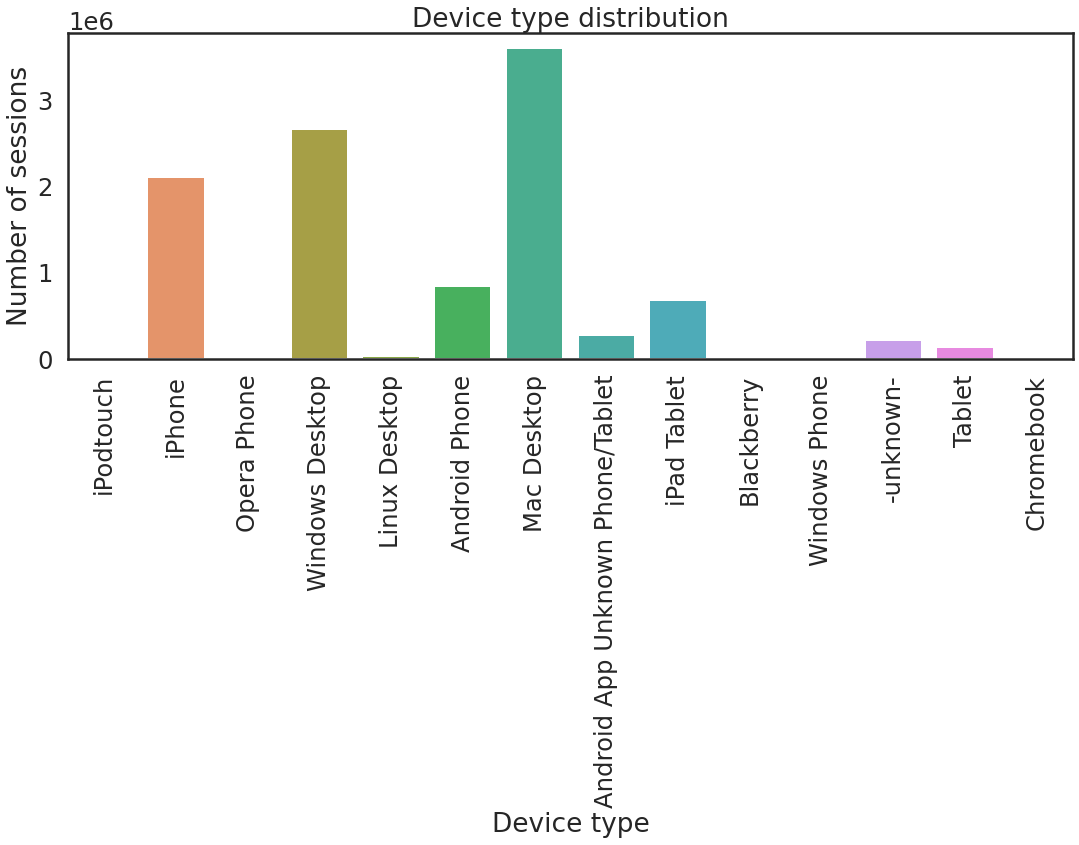

In [369]:
df_device_type = dfSessions.groupBy("device_type").count().select(["device_type", "count"]).toPandas()


plt.figure(figsize=(18,6))
sns.barplot(x='device_type', y ='count', data=df_device_type)
plt.xlabel('Device type')
plt.ylabel('Number of sessions')
plt.title('Device type distribution')
plt.xticks(rotation=90)
plt.show()


As we have discvoered earlier, from sessions.csv we find out that; most of the user interaction comes from Mac Desktop.

In [370]:
# filtering ndf destinations from dataset
dfUser_without_ndf = dfUser.filter(dfUser["country_destination"] != "NDF")

In [371]:
# joining two table on id columns

df_joined = dfUser_without_ndf.join(dfSessions, dfUser_without_ndf["id"] == dfSessions["user_id"], how="left")
df_joined.show()

+----------+--------------------+----------------------+------------------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------------+-----------+--------------------+-----------+------------+
|        id|date_account_created|timestamp_first_active|date_first_booking|gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|              action|action_type|       action_detail|device_type|secs_elapsed|
+----------+--------------------+----------------------+------------------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------------+-----------+--------------------+-----------+---

In [372]:
df_joined.columns

['id',
 'date_account_created',
 'timestamp_first_active',
 'date_first_booking',
 'gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination',
 'user_id',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'secs_elapsed']

In [373]:
df_joined.describe().show()

+-------+----------+--------------------+----------------------+------------------+-------+------------------+-------------+-----------------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+------------------+---------------+-------------+-----------+------------------+
|summary|        id|date_account_created|timestamp_first_active|date_first_booking| gender|               age|signup_method|      signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|            action|    action_type|action_detail|device_type|      secs_elapsed|
+-------+----------+--------------------+----------------------+------------------+-------+------------------+-------------+-----------------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-----------

In [374]:
df_joined.printSchema()

root
 |-- id: string (nullable = true)
 |-- date_account_created: string (nullable = true)
 |-- timestamp_first_active: long (nullable = true)
 |-- date_first_booking: string (nullable = true)
 |-- gender: string (nullable = true)
 |-- age: double (nullable = true)
 |-- signup_method: string (nullable = true)
 |-- signup_flow: integer (nullable = true)
 |-- language: string (nullable = true)
 |-- affiliate_channel: string (nullable = true)
 |-- affiliate_provider: string (nullable = true)
 |-- first_affiliate_tracked: string (nullable = true)
 |-- signup_app: string (nullable = true)
 |-- first_device_type: string (nullable = true)
 |-- first_browser: string (nullable = true)
 |-- country_destination: string (nullable = true)
 |-- user_id: string (nullable = true)
 |-- action: string (nullable = true)
 |-- action_type: string (nullable = true)
 |-- action_detail: string (nullable = true)
 |-- device_type: string (nullable = true)
 |-- secs_elapsed: double (nullable = true)



## Feature Engineering

In [375]:
#dropping first booking date, as it is irrelevant for the target
df_joined = df_joined.drop(df_joined["date_first_booking"])

In [376]:
#converting timestamp into a date format
df2 = df_joined.withColumn("timestamp_first_active", (df_joined["timestamp_first_active"] / 1000000).cast(DoubleType()))
df_joined = df2.withColumn("timestamp_first_active", col("timestamp_first_active").cast("timestamp"))
df_joined.show()

+----------+--------------------+----------------------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------------+-----------+--------------------+-----------+------------+
|        id|date_account_created|timestamp_first_active|gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|              action|action_type|       action_detail|device_type|secs_elapsed|
+----------+--------------------+----------------------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------------+-----------+--------------------+-----------+------------+
|01r3iatdvv|          2014-02-11|  1970-08-22 

In [377]:
#divide date related columns to day, month, year columns
df_joined = df_joined.withColumn("year_account_created", func.year(func.to_timestamp("date_account_created", "yyyy-mm-dd")))
df_joined = df_joined.withColumn("month_account_created", func.month(func.to_timestamp("date_account_created", "yyyy-MM-dd")))

#calculate date difference between account created date and first active date.
df_joined = df_joined.withColumn("date_difference", datediff(col("date_account_created"),col("timestamp_first_active")))

#dropping existing date_account_created and time stamp first active columns
df_joined = df_joined.drop("date_account_created")
df_joined = df_joined.drop("timestamp_first_active")

df_joined.show(5)

+----------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------+-----------+--------------------+-----------+------------+--------------------+---------------------+---------------+
|        id|gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|        action|action_type|       action_detail|device_type|secs_elapsed|year_account_created|month_account_created|date_difference|
+----------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------+-----------+--------------------+-----------+------------+--------------------+---------------------+---------------+
|01r3iatdvv|  null|

In [378]:
#filling null values in ages column with -1
df_joined = df_joined.fillna(-1, subset=['age'])
df_joined.show(5)

+----------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------+-----------+--------------------+-----------+------------+--------------------+---------------------+---------------+
|        id|gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|        action|action_type|       action_detail|device_type|secs_elapsed|year_account_created|month_account_created|date_difference|
+----------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------+-----------+--------------------+-----------+------------+--------------------+---------------------+---------------+
|01r3iatdvv|  null|

In [379]:
#change action_detail -unknown- entries into null

df_joined = df_joined.withColumn("action_detail", func.when(df_joined["action_detail"]=="-unknown-",None).otherwise(df_joined["action_detail"]))
df_joined.show(5)

+----------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------+-----------+--------------------+-----------+------------+--------------------+---------------------+---------------+
|        id|gender| age|signup_method|signup_flow|language|affiliate_channel|affiliate_provider|first_affiliate_tracked|signup_app|first_device_type|first_browser|country_destination|   user_id|        action|action_type|       action_detail|device_type|secs_elapsed|year_account_created|month_account_created|date_difference|
+----------+------+----+-------------+-----------+--------+-----------------+------------------+-----------------------+----------+-----------------+-------------+-------------------+----------+--------------+-----------+--------------------+-----------+------------+--------------------+---------------------+---------------+
|01r3iatdvv|  null|

# LightGBM Model 

In [380]:
import lightgbm as lgb

In [381]:
#removed unnecessary id fields from data
df_joined = df_joined.drop("id")
df_joined = df_joined.drop("user_id")
df_joined.columns

['gender',
 'age',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'country_destination',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'secs_elapsed',
 'year_account_created',
 'month_account_created',
 'date_difference']

In [382]:
categorical_features = [                       
  'gender',
  'country_destination',
 'signup_method',
 'signup_flow',
 'language',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'year_account_created',
 'month_account_created'
 ]

def cat_to_index(categorical_features):
  indexed_categorical_features=[]
  for cat_feat in categorical_features:
    cat_feat+="_indexed"
    indexed_categorical_features.append(cat_feat)
  return indexed_categorical_features


indexed_categorical_features = cat_to_index(categorical_features)

In [383]:
#ÖNEMLİ!!!
from pyspark.ml.feature import StringIndexer
#get numeric results from categorical variables to use in lightgbm

#bunun skip edilmesine tekrar dönüp bak!...
stringIndexer = StringIndexer(inputCols=categorical_features, outputCols=indexed_categorical_features, handleInvalid="skip")
indexed_df = stringIndexer.fit(df_joined).transform(df_joined)

In [384]:
#dropping stringtype categorical features from dataframe
indexed_df = indexed_df.drop('gender',
 'signup_method',
 'signup_flow',
 'language',
 'country_destination',
 'affiliate_channel',
 'affiliate_provider',
 'first_affiliate_tracked',
 'signup_app',
 'first_device_type',
 'first_browser',
 'action',
 'action_type',
 'action_detail',
 'device_type',
 'year_account_created',
 'month_account_created')

indexed_df.show()

+----+------------+---------------+----------------------------+---------------------------+---------------------+--------------------------+----------------+-------------------------+-------------------+-------------------+------------------+---------------------+--------------+-----------------------------+-------------------+--------------+-------------------------------+---------------------+-------------------------+
| age|secs_elapsed|date_difference|year_account_created_indexed|country_destination_indexed|first_browser_indexed|affiliate_provider_indexed|language_indexed|affiliate_channel_indexed|signup_flow_indexed|device_type_indexed|signup_app_indexed|signup_method_indexed|action_indexed|month_account_created_indexed|action_type_indexed|gender_indexed|first_affiliate_tracked_indexed|action_detail_indexed|first_device_type_indexed|
+----+------------+---------------+----------------------------+---------------------------+---------------------+--------------------------+-------

In [385]:
#train-test split
train, test = indexed_df.randomSplit([0.7,0.3], seed= 100)

#seperate features and label into different dataframes
x_train = np.array(train.drop("country_destination_indexed").collect())
y_train = np.array(train.select("country_destination_indexed").collect()).ravel() #ravel - flattens array dimension to 1d array
x_test = np.array(test.drop("country_destination_indexed").collect())
y_test = np.array(test.select("country_destination_indexed").collect())

In [386]:
feature_name = ['age',
 'secs_elapsed',
 'date_difference',
 'year_account_created_indexed',
 'first_browser_indexed',
 'affiliate_provider_indexed',
 'language_indexed',
 'affiliate_channel_indexed',
 'signup_flow_indexed',
 'device_type_indexed',
 'signup_app_indexed',
 'signup_method_indexed',
 'action_indexed',
 'month_account_created_indexed',
 'action_type_indexed',
 'gender_indexed',
 'first_affiliate_tracked_indexed',
 'action_detail_indexed',
 'first_device_type_indexed']

categorical_features = [
  'year_account_created_indexed',
 'first_browser_indexed',
 'affiliate_provider_indexed',
 'language_indexed',
 'affiliate_channel_indexed',
 'signup_flow_indexed',
 'device_type_indexed',
 'signup_app_indexed',
 'signup_method_indexed',
 'action_indexed',
 'month_account_created_indexed',
 'action_type_indexed',
 'gender_indexed',
 'first_affiliate_tracked_indexed',
 'action_detail_indexed',
 'first_device_type_indexed']

In [387]:
train_data = lgb.Dataset(x_train, label=y_train, categorical_feature=categorical_features, feature_name= feature_name)

In [388]:
params = {}
params['learning_rate']= 0.003
params['boosting_type']='gbdt'
params['objective']='binary'
params['metric']='binary_logloss'
params['sub_feature']=0.5
params['num_leaves']= 10
params['min_data']=50
params['max_depth']=10

In [389]:
eval_result = {} #to keep evaluation results for plotting

#training model
clf = lgb.train(params, train_data, evals_result=eval_result, verbose_eval=100)

In [390]:
from sklearn.metrics import accuracy_score, mean_squared_error, r2_score
y_pred = clf.predict(x_test)

print ("accuracy_score :",accuracy_score(y_test,y_pred.astype(int)))
print ("root mean squared error :",mean_squared_error(y_test,y_pred.astype(int), squared=False))
print("r2 score: ", r2_score(y_test, y_pred.astype(int)))

accuracy_score : 0.6942354141641157
root mean squared error : 1.9976982660555798
r2 score:  -0.23676506795200392


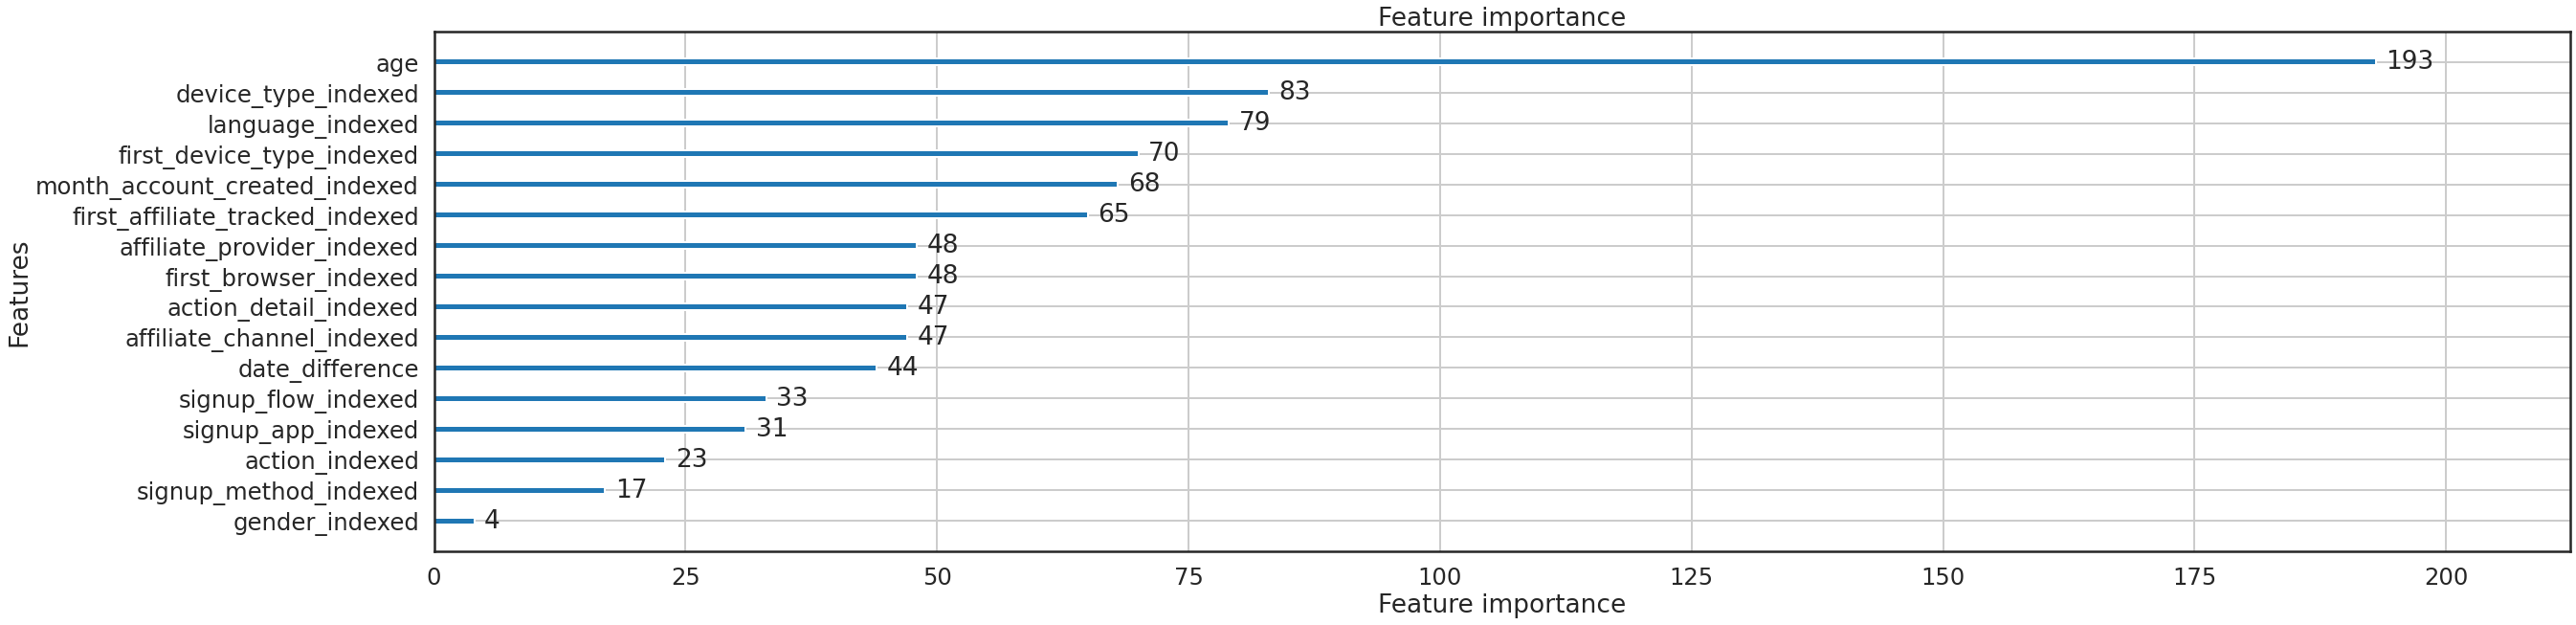

In [391]:
#plotting feature importance
ax = lgb.plot_importance(clf)
fig = ax.figure
fig.set_size_inches(40,10)
plt.show()